In [1]:
# import os
import SunStatistics as SS
from scipy.stats import pearsonr

# import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta,datetime
import pytz

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

G_Drive = 'G:\\My Drive\\'
G_Drive = 'C:\\Users\\User\\Google Drive\\'
Output_Path = G_Drive+'FishIsland_Outputs/'

# Model Functions

In [2]:
def Model_Test_RF(X,y,AllData,K=10,Task = 'Predict',min_samples_split=None,Verbose=True,random_state=1):
    Data = AllData[X+y].dropna()
    kf = KFold(n_splits=K,shuffle=True, random_state = random_state)
    R2 = []
    MSE = []
    Imp = []    
    Pred = []
    rnd=1
    for train_index, test_index in kf.split(Data):
        df_test = Data.iloc[test_index]
        df_train = Data.iloc[train_index]
        X_train = np.array(df_train[X])#.reshape(-1, 1)     
        y_train = np.array(df_train[y]).ravel()#.reshape(-1, 1)
        X_test = np.array(df_test[X])#.reshape(-1, 1)  
        y_test = np.array(df_test[y]).ravel()#.reshape(-1, 1)
        Mod = RandomForestRegressor(min_samples_split=min_samples_split, random_state=random_state+rnd)#,bootstrap=False)
        rnd+=1
        Mod.fit(X_train, y_train)
        Test = Mod.predict(X_test)
        Pred.append(Mod.predict(AllData[X]))
        R2.append(metrics.r2_score(y_test,Test))
        MSE.append(metrics.mean_squared_error(y_test,Test))
        Imp.append(Mod.feature_importances_)
    Imp = np.mean(np.array(Imp),axis=0)
    Pred = np.mean(np.array(Pred),axis=0)
    if Verbose == True:
        print()
        print(y[0])
        print('RMSE', np.mean(np.array(MSE)**.5))
        print('std RMSE', np.std(np.array(MSE)**.5))
        print('r2', np.median(np.array(R2)))
        print('Imp',np.round(Imp,3)*100)
    if Task == 'Predict':
        return(Pred)
    if Task == 'Predict_Return':
        return(Pred,Imp,MSE,R2)
    elif Task == 'Optimize':
        return(MSE)

def Model_Test_OLS(X,y,AllData,K=10,Task = 'Predict',fit_intercept=None,Scale=False,Verbose=True,random_state=1):
    if Scale==True:
        Mod = make_pipeline(StandardScaler(), LinearRegression(fit_intercept=fit_intercept))
    else:
        Mod = make_pipeline(LinearRegression(fit_intercept=fit_intercept))
    Data = AllData[X+y].dropna()
    kf = KFold(n_splits=K,shuffle=True, random_state = random_state)
    R2 = []
    MSE = []
    Int = []
    Coef = []
    Pred = []
    for train_index, test_index in kf.split(Data):
        df_test = Data.iloc[test_index]
        df_train = Data.iloc[train_index]
        X_train = np.array(df_train[X])#.reshape(-1, 1)     
        y_train = np.array(df_train[y])#.reshape(-1, 1)
        X_test = np.array(df_test[X])#.reshape(-1, 1)  
        y_test = np.array(df_test[y])#.reshape(-1, 1)
        Mod.fit(X_train, y_train)
        Test = Mod.predict(X_test)
        if y == ['VPD'] or y == ['PPFD_Avg']:
            Test[Test<0]=0
        
        R2.append(metrics.r2_score(y_test,Test))
        MSE.append(metrics.mean_squared_error(y_test,Test))
        Pred.append(Mod.predict(AllData[X]))
        Int.append(Mod[-1].intercept_)
        Coef.append(Mod[-1].coef_)
    Coef = np.mean(np.array(Coef),axis=0).mean(axis=0)
    Pred = np.mean(np.array(Pred),axis=0)#.mean(axis=0)
    Int = np.mean(np.array(Int))
    if Verbose == True:
        print()
        print(y[0])
        print('RMSE', np.mean(np.array(MSE)**.5))
        print('std RMSE', np.std(np.array(MSE)**.5))
        print('r2', np.median(np.array(R2)))
        print('coef', Coef)
        print('int',Int)
    if Task == 'Predict':
        return(Pred)#.values)
    if Task == 'Predict_Return':
        return(Pred,Coef,Int,MSE,R2)
    elif Task == 'Optimize':
        return(MSE)
    
def Model_Test(X,y,AllData,K=10,Task = 'Predict',Test = 'OLS',min_samples_split=None,fit_intercept=True,Scale=False,Verbose=True,random_state=1):
    if Test == 'OLS':
        return(Model_Test_OLS(X,y,AllData,K=10,Task = Task,fit_intercept=fit_intercept,Scale=Scale,Verbose=Verbose,random_state=random_state))
    elif Test == 'RF':
        return(Model_Test_RF(X,y,AllData,K=10,Task = Task,min_samples_split=min_samples_split,Verbose=Verbose,random_state=random_state))
    

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues


In [3]:

def get_uv(Dir,U_bar,dec=0):
    M_dir = 270-(Dir+dec)
    U = np.cos(M_dir/180*np.pi)*U_bar
    V = np.sin(M_dir/180*np.pi)*U_bar
    return(U,V)
def get_wDir(u,v,m_dec=0):
    W_dir = np.arctan2(v,u)*180/np.pi
    W_dir = 270 - W_dir    
    W_dir[W_dir>360]-=360
    return(W_dir)

# Data

In [4]:
Taglu_Data = Output_Path+'Taglu_Data/Hourly.csv'
AWS = pd.read_csv(Taglu_Data,
parse_dates={'datetime':['Year','Month','Day','Time']}, 
).set_index('datetime')

# Gap Fill
C=['Air Temp','Net Radiation','Net SW Radiation','Net LW Radiation ','Wind Speed']
s = AWS.index.to_series()
print('Missing')
for c in C:
    print(c,AWS.loc[((AWS.index.month>=4)&(AWS.index.month<=10)),c].isnull().sum())
    miss = AWS[c].isna()
    #create consecutive groups
    g = miss.ne(miss.shift()).cumsum()
    #aggregate minimal 
    m1 = s.groupby(g).min()
    #get minimal of next groups, last value is replaced last value of index
    m2 = m1.shift(-1).fillna(AWS.index[-1])
    #get difference, convert to minutes
    out = m2.sub(m1).dt.total_seconds().div(3600).astype(int)
    AWS['Temp_Gap'] = g.map(out)
    AWS['Temp']=AWS[c].interpolate()
    AWS.loc[AWS['Temp_Gap']<=4,c]=AWS.loc[AWS['Temp_Gap']<=4,'Temp']
    AWS['Temp1']=AWS[c].shift(24)
    AWS['Temp2']=AWS[c].shift(-24)
    AWS.loc[AWS['Temp_Gap']>=4,c].fillna(AWS.loc[AWS['Temp_Gap']>=4,['Temp1','Temp2']].mean(axis=1))
AWS = AWS.drop(columns=['Temp_Gap','Temp','Temp1','Temp2'])
AWS_Rename = {'Air Temp':'Air_Temp',
              'Rainfall':'Rainfall',
              'Wind Speed':'Wind_Speed',
              'Wind direction':'Wind_Direction',
              'Net SW Radiation':'Net_SW',
              'Net LW Radiation ':'Net_LW',
              'Net Radiation':'Net_RN'}
AWS = AWS.rename(columns=AWS_Rename)
AWS_cols = list(AWS_Rename.values())

LAT = 69.371182
LON = -134.880935
TZ = -6

Temp = AWS[['Net_SW']].resample('5T').asfreq()
D = Temp.index.floor('D').to_julian_date()
T = Temp.index.hour/24
A = np.ones(D.shape[0])

Zenith,Angle,Angle_Corr,Azimuth,Sunrise,Sunset=SS.SunStats(LAT*A,LON*A,D.values,T.values,TZ*A)
Temp['Sun_Angle'] = Angle_Corr
Temp = Temp.resample('30T').mean()
try:
    AWS = AWS.drop(columns=['Sun_Angle'])
except:
    pass
AWS = AWS.join(Temp[['Sun_Angle']])

AWS['Daytime']=0
AWS.loc[AWS['Sun_Angle']>-0.5,'Daytime']=1

AWS.loc[((AWS['Daytime']==0)&(AWS['Net_SW']>3)),'Daytime']=0.5


Mt = pytz.timezone('Canada/Mountain')
UTC = AWS.index+timedelta(hours=6)
AWS = AWS.set_index(UTC)
AWS.index = AWS.index.tz_localize(pytz.utc).tz_convert(Mt)

U,V = get_uv(AWS['Wind_Direction'],AWS['Wind_Speed'])
AWS['U_bar_AWS'] = U
AWS['V_bar_AWS'] = V

AWS.groupby('Daytime').count()['Air_Temp']

print(AWS['Air_Temp'].dropna())

Missing
Air Temp 40
Net Radiation 40
Net SW Radiation 40
Net LW Radiation  40
Wind Speed 40


C:\Users\User\FishIsland_Flux_Analysis\FluxProcessing\SunStatistics.py:25: RuntimeWarning: invalid value encountered in arccos
  W2 = np.degrees(np.arccos(np.cos(np.radians(90.833))/(np.cos(np.radians(LAT))*np.cos(np.radians(T2)))-np.tan(np.radians(LAT))*np.tan(np.radians(T2)))) #HA Sunrise (deg)


datetime
2008-08-28 00:00:00-06:00     6.0
2008-08-28 01:00:00-06:00     5.6
2008-08-28 02:00:00-06:00     5.1
2008-08-28 03:00:00-06:00     4.7
2008-08-28 04:00:00-06:00     4.8
                             ... 
2020-08-11 10:00:00-06:00     9.5
2020-08-11 11:00:00-06:00     9.8
2020-08-11 12:00:00-06:00    10.0
2020-08-11 13:00:00-06:00    10.6
2020-08-11 14:00:00-06:00    10.8
Name: Air_Temp, Length: 104761, dtype: float64


# EC Data

In [5]:
EC_Data = pd.read_csv(Output_Path+'FI_Footprints_2022-02-23_2000mx2m.csv',delimiter = ',',header = 0,na_values = -9999,
                   index_col=['datetime'],
                  ).drop('Unnamed: 0',axis=1)
EC_Data = EC_Data.set_index(pd.to_datetime(EC_Data.index, utc=True)).tz_convert(Mt)
EC_Data = EC_Data.rename(columns={'Daytime':'Daytime_Raw',
                                 'Sun_Angle':'Sun_Angle_Raw'})

U,V=get_uv(EC_Data['wind_dir'],EC_Data['wind_speed'],dec=-22)
EC_Data['U_bar_EC']=U
EC_Data['V_bar_EC']=V

FSO = pd.read_csv(Output_Path+'Skeeter_et_al_2022_Day_Fix.csv',index_col=['datetime']).drop('Unnamed: 0',axis=1)#.drop('datetime.1',axis=1)

FSO = FSO.set_index(pd.to_datetime(FSO.index, utc=True)).tz_convert(Mt)
FSO = FSO.rename(columns={'NEE_est':'NEE_FSO',
                            'NME_est':'NME_FSO'})
EC_Data = EC_Data.join(FSO[['NEE_FSO',
'NME_FSO']])

kwargs = {'closed':'right','label':'left'}
EC_Data_r=EC_Data.resample('h',**kwargs).mean()
EC_Data_r['Rain_mm_Tot']=EC_Data.resample('h',**kwargs).sum()['Rain_mm_Tot']

EC_Data_r = EC_Data_r.drop(['Wind_Direction', 'Wind_Speed'],axis=1)
Data_M1 = EC_Data_r[
                    ['Temp_15_1','Temp_15_2','Temp_5_1','Temp_5_2','Table_1','VWC_1','Tdew','VPD','H',
                    'AirTC_Avg','PPFD_Avg','NR_Wm2_Avg','Rain_mm_Tot','Active_Layer_1',
                    'wind_speed','u*','U_bar_EC','V_bar_EC','Polygon','Rim',
                    'fch4','fco2','NEE_FSO','NME_FSO','ch4_flux','co2_flux']
                    ].join(AWS,how='outer')
Data_M1.head()

,Temp_15_1,Temp_15_2,Temp_5_1,Temp_5_2,Table_1,VWC_1,Tdew,VPD,H,AirTC_Avg,...,Rainfall,Wind_Speed,Wind_Direction,Net_SW,Net_LW,Net_RN,Sun_Angle,Daytime,U_bar_AWS,V_bar_AWS
datetime,,,,,,,,,,,,,,,,,,,,,
2008-08-28 00:00:00-06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,3.0,53.88,-0.53,-6.99,-7.51,-5.063956,0.0,-2.423352,-1.768435
2008-08-28 01:00:00-06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,3.2,56.81,-0.54,-6.18,-6.71,-8.302563,0.0,-2.677952,-1.751735
2008-08-28 02:00:00-06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,3.2,57.65,-0.55,-6.35,-6.90,-10.355872,0.0,-2.703345,-1.712287
2008-08-28 03:00:00-06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,2.9,56.24,-0.51,-5.40,-5.90,-11.078917,0.0,-2.410981,-1.611574
2008-08-28 04:00:00-06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,2.4,68.13,-0.44,-5.17,-5.61,-10.416418,0.0,-2.227275,-0.894005


# Merge

- Eddypro outputs have left labels (half hour timestamp corresponds to end of interval)
    * https://www.licor.com/documents/1ium2zmwm6hl36yz9bu4
- Need to close the right interval to match with AWS

In [6]:
for v1,v2 in zip(['Rain_mm_Tot','AirTC_Avg','wind_speed','NR_Wm2_Avg'],
                 ['Rainfall','Air_Temp','Wind_Speed','Net_RN']):
    DNA=Data_M1.loc[Data_M1['Active_Layer_1'].isnull()==False,[v1,v2]].dropna()
    print(v1,' ',v2)
    print('r2: ',(DNA[[v1,v2]].corr()**2)[v1].round(3)[1])
    print('RMSE: ',(metrics.mean_squared_error(DNA[v1],DNA[v2])**.5).round(3))
    print('MBE: ',np.round((DNA[v1]-DNA[v2]).mean(),2))
    print()

Rain_mm_Tot   Rainfall
r2:  0.988
RMSE:  0.05
MBE:  -0.01

AirTC_Avg   Air_Temp
r2:  0.988
RMSE:  0.547
MBE:  -0.09

wind_speed   Wind_Speed
r2:  0.945
RMSE:  0.43
MBE:  0.0

NR_Wm2_Avg   Net_RN
r2:  0.978
RMSE:  43.069
MBE:  9.45



# ECMWF

- ECMWF data does not account for DST
    - Must offset by one hour so summer times match

In [7]:
ECMWF = pd.read_csv(G_Drive+'earthengine//Climate_Weighted_Mean_long.csv',
                    parse_dates=['system:index'],na_values=-9999,index_col=['system:index'])

UTC = ECMWF.index+timedelta(hours=-1)
ECMWF = ECMWF.set_index(UTC)
ECMWF.index = ECMWF.index.tz_localize(pytz.utc).tz_convert(Mt)
ECMWF = ECMWF.drop(columns=['.geo'])

ECMWF['Wind_10m']  =(ECMWF['u_component_of_wind_10m']**2+ECMWF['v_component_of_wind_10m']**2)**.5
ECMWF['HH']=ECMWF['surface_sensible_heat_flux_hourly']/3609*-1
for v in ['temperature_2m' ,'soil_temperature_level_1','soil_temperature_level_2','soil_temperature_level_3']:
    ECMWF[v]-=273.15
ECMWF['total_precipitation_hourly']=ECMWF['total_precipitation_hourly']*1000
ECMWF['RN']=ECMWF[[
    'surface_net_solar_radiation_hourly',
    'surface_net_thermal_radiation_hourly'
]].sum(axis=1)/3609

Data_M2 = Data_M1.join(ECMWF.loc[ECMWF.index.year>=2008],how = 'outer')

Data_M2['W_Dir_ERA5'] = get_wDir(Data_M2['u_component_of_wind_10m'].values,Data_M2['v_component_of_wind_10m'].values)
Data_M2['W_Dir_EC'] = get_wDir(Data_M2['U_bar_EC'].values,Data_M2['V_bar_EC'].values)

Data_M2['Wind_Direction']=Data_M2['Wind_Direction'].fillna(Data_M2['W_Dir_ERA5'])

,W_Dir_ERA5,Wind_Direction
W_Dir_ERA5,1.00000,0.78019
Wind_Direction,0.78019,1.00000


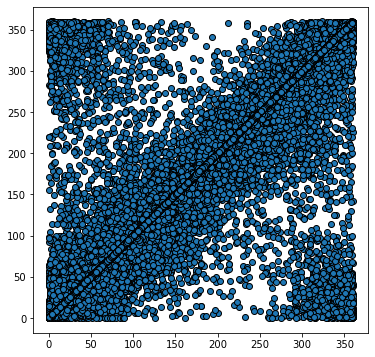

In [8]:

# DNA = Data_M2[['W_Dir_ERA5','Wind_Direction','W_Dir_EC']].dropna()
DNA = Data_M2.loc[((Data_M2.index.month>=5)&(Data_M2.index.month<=10)),['W_Dir_ERA5','Wind_Direction']].dropna()

plt.figure(figsize=(6,6))
plt.scatter(DNA['W_Dir_ERA5'],DNA['Wind_Direction'],edgecolor='k')
# plt.scatter(DNA['W_Dir_EC'],DNA['Wind_Direction'],edgecolor='k')

DNA[['W_Dir_ERA5','Wind_Direction']].corr()



In [9]:
InSitu = ['AirTC_Avg','Air_Temp','Tdew',
          'wind_speed','Wind_Speed','H','NR_Wm2_Avg','Net_RN']
ERA5 = ['temperature_2m','temperature_2m','dewpoint_temperature_2m',
        'Wind_10m','Wind_10m','HH','RN','RN']

for v1,v2 in zip(InSitu,ERA5):#,'Wind_Speed','Net_RN']):
    DNA=Data_M2.loc[((Data_M2.index.month>=5)&(Data_M2.index.month<=10)),[v1,v2]].dropna()
    print(v1,v2)
#     if v1 == 'H':
#         DNA[v2]/=-3600
    print('r2: ',(DNA[[v1,v2]].corr()**2)[v1].round(2)[1])
    print('RMSE: ',(metrics.mean_squared_error(DNA[v1],DNA[v2])**.5).round(3))
    print('MBE: ',np.round((DNA[v1]-DNA[v2]).mean(),2))
    print()

AirTC_Avg temperature_2m
r2:  0.91
RMSE:  1.52
MBE:  0.53

Air_Temp temperature_2m
r2:  0.93
RMSE:  2.068
MBE:  -0.14

Tdew dewpoint_temperature_2m
r2:  0.85
RMSE:  1.682
MBE:  1.06

wind_speed Wind_10m
r2:  0.69
RMSE:  1.192
MBE:  -0.59

Wind_Speed Wind_10m
r2:  0.68
RMSE:  1.241
MBE:  -0.51

H HH
r2:  0.81
RMSE:  31.643
MBE:  -8.89

NR_Wm2_Avg RN
r2:  0.89
RMSE:  60.73
MBE:  13.45

Net_RN RN
r2:  0.86
RMSE:  51.625
MBE:  5.19



In [10]:
InSitu = ['Temp_5_1','Temp_5_2','Temp_5_1','Temp_5_2',
          'Temp_15_1','Temp_15_2','Temp_15_1','Temp_15_2',
          'VWC_1','VWC_1','Table_1','Table_1']
ERA5 = ['soil_temperature_level_1','soil_temperature_level_1','soil_temperature_level_2',
        'soil_temperature_level_2','soil_temperature_level_2','soil_temperature_level_2',
        'soil_temperature_level_3','soil_temperature_level_3',
        'volumetric_soil_water_layer_1','volumetric_soil_water_layer_2',
        'volumetric_soil_water_layer_1','volumetric_soil_water_layer_2']

for v1,v2 in zip(InSitu,ERA5):#,'Wind_Speed','Net_RN']):
    DNA=Data_M2.loc[((Data_M2.index.month>=5)&(Data_M2.index.month<=10)),[v1,v2]].dropna()
    print(v1,v2)
#     if v1 == 'H':
#         DNA[v2]/=-3600
    print('r2: ',(DNA[[v1,v2]].corr()**2)[v1].round(2)[1])
    print('RMSE: ',(metrics.mean_squared_error(DNA[v1],DNA[v2])**.5).round(3))
    print('MBE: ',np.round((DNA[v1]-DNA[v2]).mean(),3))
    print()

Temp_5_1 soil_temperature_level_1
r2:  0.43
RMSE:  7.169
MBE:  -5.912

Temp_5_2 soil_temperature_level_1
r2:  0.75
RMSE:  4.625
MBE:  -3.645

Temp_5_1 soil_temperature_level_2
r2:  0.67
RMSE:  4.928
MBE:  -4.58

Temp_5_2 soil_temperature_level_2
r2:  0.57
RMSE:  3.254
MBE:  -2.324

Temp_15_1 soil_temperature_level_2
r2:  0.09
RMSE:  8.332
MBE:  -7.754

Temp_15_2 soil_temperature_level_2
r2:  0.09
RMSE:  8.213
MBE:  -7.634

Temp_15_1 soil_temperature_level_3
r2:  0.32
RMSE:  4.325
MBE:  -4.059

Temp_15_2 soil_temperature_level_3
r2:  0.36
RMSE:  4.175
MBE:  -3.92

VWC_1 volumetric_soil_water_layer_1
r2:  0.29
RMSE:  0.084
MBE:  -0.03

VWC_1 volumetric_soil_water_layer_2
r2:  0.55
RMSE:  0.075
MBE:  -0.069

Table_1 volumetric_soil_water_layer_1
r2:  0.81
RMSE:  0.376
MBE:  -0.37

Table_1 volumetric_soil_water_layer_2
r2:  0.85
RMSE:  0.41
MBE:  -0.41



# Correlations

In [11]:
V = ['Temp_5_1','Temp_5_2',
    'Temp_15_1','Temp_15_2',
    'VWC_1','Table_1',
    'soil_temperature_level_1',
    'soil_temperature_level_2',
    'soil_temperature_level_3',
    'volumetric_soil_water_layer_1',
    'volumetric_soil_water_layer_2',
   ]
B = ['Temp_5_1','Temp_5_2',
   'Temp_15_1','Temp_15_2','VWC_1','Table_1']
P = calculate_pvalues(Data_M2[V])[B][-5:].T.astype(float)

# P[P<=0.05]=-1
# P[P>0.05]=0
P=P*0+1
D =(Data_M2[V].corr()[B][-5:].T**2).round(3)

PR = (P * D)

PR.to_csv(G_Drive+'\\PhD_Thesis\\Chapter3_Figs/Pearsonr.csv')
PR


,soil_temperature_level_1,soil_temperature_level_2,soil_temperature_level_3,volumetric_soil_water_layer_1,volumetric_soil_water_layer_2
Temp_5_1,0.427,0.668,0.319,0.221,0.267
Temp_5_2,0.748,0.567,0.130,0.233,0.262
Temp_15_1,0.021,0.086,0.315,0.006,0.000
Temp_15_2,0.012,0.090,0.358,0.007,0.000
VWC_1,0.245,0.542,0.737,0.286,0.553
Table_1,0.435,0.721,0.282,0.808,0.849


Rainfall total_precipitation_hourly
r2:  0.58
RMSE:  1.686
MBE:  -0.36

Rain_mm_Tot total_precipitation_hourly
r2:  0.5
RMSE:  2.679
MBE:  -0.73



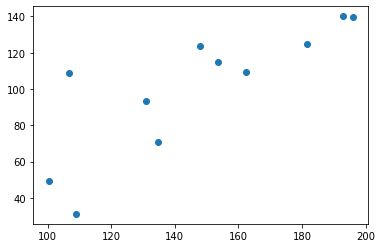

In [12]:
Daily = Data_M2.resample('D').sum()
InSitu=['Rainfall','Rain_mm_Tot']
ERA5=['total_precipitation_hourly','total_precipitation_hourly']
for v1,v2 in zip(InSitu,ERA5):
    DNA=Data_M2.loc[((Data_M2.index.month>=6)&(Data_M2.index.month<=9)&(Data_M2.index.year>=2009)&(Data_M2.index.year<=2019)),[v1,v2]].dropna()
    DNA = DNA.resample('D').mean().dropna()*24
    print(v1,v2)
    print('r2: ',(DNA[[v1,v2]].corr()**2)[v1].round(2)[1])
    print('RMSE: ',(metrics.mean_squared_error(DNA[v1],DNA[v2])**.5).round(3))
    print('MBE: ',np.round((DNA[v1]-DNA[v2]).mean(),2))
    print()

Y = Daily.loc[((Daily.index.month>=6)&(Daily.index.month<=9)&(Daily.index.year>=2009)&(Daily.index.year<=2019))].resample('Y').sum()    

plt.figure()
plt.scatter(Y['total_precipitation_hourly'],Y['Rainfall'])

# Satelite & Stream

In [13]:
Gaus_interp_s = 2
Gaus_interp_p = 8
Gaus_interp_d = 32

NDVI = pd.read_csv(G_Drive+'earthengine/NDVI_NBAR_LCP.csv',parse_dates=['date'],na_values=-9999)
NDVI = NDVI.set_index(pd.DatetimeIndex(NDVI['date']))
NDVI=NDVI.drop(['date','.geo','system:index'],axis=1)
NDVI.index = NDVI.index.tz_localize(pytz.utc).tz_convert(Mt)


GPP = pd.read_csv(G_Drive+'earthengine/GPP_FI_LCP.csv',
                  parse_dates=['date'],na_values=-9999,index_col=['date']).dropna()
GPP.index = GPP.index.tz_localize(pytz.utc).tz_convert(Mt)

Snow = pd.read_csv(G_Drive+'earthengine/NDSI_LCP.csv',
                   parse_dates=['date'],na_values=['-9999'])
Snow = Snow.set_index(pd.DatetimeIndex(Snow['date']))
Snow=Snow.drop(['date','.geo','system:index'],axis=1)
Snow.index = Snow.index.tz_localize(pytz.utc).tz_convert(Mt)

Satelite = NDVI.join(Snow).join(GPP[['GPP_FI_LCP']])

print('Completeness')
Temp = Satelite.loc[((Satelite.index.year>=2008)&(Satelite.index.year<=2020)&
                    (Satelite.index.month>=5)&(Satelite.index.month<=10))]

# print(Temp.resample('Y').count())
print(Temp.shape[0]-Temp.count())
print((Temp.count()/Temp.shape[0]).round(3))


Temp = GPP.loc[((GPP.index.month>=5)&(GPP.index.month<=10))]
print(Temp.shape[0]-Temp.count())
print((Temp.count()/Temp.shape[0]).round(3))


Satelite['NDSI_fill'] = Satelite['NDSI_FI_LCP'].rolling(Gaus_interp_d,center=True,min_periods=Gaus_interp_p, 
                                              win_type='gaussian').mean(std=Gaus_interp_s)
Satelite['NDSI_interp']=Satelite['NDSI_FI_LCP'].fillna(Satelite['NDSI_fill'])

Satelite['NDVI_fill'] = Satelite['ndvi_FI_LCP'].rolling(Gaus_interp_d,center=True,min_periods=Gaus_interp_p, 
                                              win_type='gaussian').mean(std=Gaus_interp_s)
Satelite['NDVI_interp']=Satelite['ndvi_FI_LCP'].fillna(Satelite['NDVI_fill'])

Satelite['GPP_interp'] = Satelite['GPP_FI_LCP'].rolling(8*4,center=True,min_periods=4, 
                                              win_type='gaussian').mean(std=Gaus_interp_s)/8

Gauge = pd.read_csv(Output_Path+'Gauge_Data.csv',
                   parse_dates=['Date'],na_values=['-9999'])
Gauge = Gauge.set_index(pd.DatetimeIndex(Gauge['Date']))
Gauge=Gauge.drop('Date',axis=1)
Gauge.loc[Gauge['EAST CHANNEL']>15,'EAST CHANNEL']=np.nan
Gauge.loc[((Gauge.index.year==2015)&(Gauge.index.dayofyear>=116)&
           (Gauge.index.dayofyear<=170)),'BIG LAKE']=np.nan
Gauge.index = Gauge.index.tz_localize(pytz.utc).tz_convert(Mt)

Data = Data_M2.join(Satelite).join(Gauge[['KULUARPAK','BIG LAKE']])
# Data.head()

Completeness
ndvi_FI_LCP     127
NDSI_FI_LCP    1124
GPP_FI_LCP     2092
dtype: int64
ndvi_FI_LCP    0.947
NDSI_FI_LCP    0.530
GPP_FI_LCP     0.125
dtype: float64
system:index    0
GPP_FI_LCP      0
.geo            0
dtype: int64
system:index    1.0
GPP_FI_LCP      1.0
.geo            1.0
dtype: float64


# Fill Params

In [14]:
Data['DOY']=Data.index.dayofyear
Data['NDSI_interp'] = Data['NDSI_interp'].interpolate()
Data['NDVI_interp'] = Data['NDVI_interp'].interpolate()


In [15]:
# print(Data['KULUARPAK'].dropna())

# Sub-Surface Fill

In [16]:
Data['Rolling_RainfallD14']=Data['Rainfall'].rolling(str(14)+'D').sum()
Data['Rolling_RainfallD6']=Data['Rainfall'].rolling(str(6)+'D').sum()
Data['Rolling_RainfallD3']=Data['Rainfall'].rolling(str(3)+'D').sum()
Data['Rolling_RainfallD']=Data['Rainfall'].rolling(str(1)+'D').sum()

# Data['Rolling_Air_Temp_D14']=Data['Air_Temp'].rolling(str(14)+'D').mean()
# Data['Rolling_Air_Temp_D6']=Data['Air_Temp'].rolling(str(6)+'D').mean()
Data['Rolling_Air_TempD3']=Data['Air_Temp'].rolling(str(3)+'D').mean()
Data['Rolling_Air_TempD']=Data['Air_Temp'].rolling(str(1)+'D').mean()

Data['Rolling_Air_TempH1']=Data['Air_Temp'].rolling(str(6)+'H').mean()
Data['Rolling_Air_TempH2']=Data['Air_Temp'].rolling(str(12)+'H').mean()
Data['Rolling_Air_TempH3']=Data['Air_Temp'].rolling(str(18)+'H').mean()

Y = 'Test'

SE_Rule = 2

Met = [
    'Net_SW',
    'Net_LW',
    'Air_Temp',
    'Rainfall'
    ]
Lag_Rain = [
    'Rolling_RainfallD3',
    ]
Lag_Air = [
    'Rolling_Air_TempH1',
    'Rolling_Air_TempH2',
    'Rolling_Air_TempH3',
    'Rolling_Air_TempD'
    ]
ERA5_Temp = [
    'soil_temperature_level_1',
    'soil_temperature_level_2',
    'soil_temperature_level_3'
    ]

ERA5_VWC = [
    'volumetric_soil_water_layer_1',
    'volumetric_soil_water_layer_2',
    ]

AllX = Met+Lag_Air+Lag_Rain+ERA5_Temp+ERA5_VWC
print(len(AllX))

Mods = {
}
for y in [['Temp_15_1'],['Temp_15_2'],['Temp_5_1'],['Temp_5_2'],['Table_1']]:
    X = AllX
    res = {
        'X':X,
        'Score':np.ones(len(X))/len(X)
    }
    Results = pd.DataFrame(data=res)
    K = 30
    Track = {'i':[],
            'Rem':[],
            'RMSE':[],
            'RMSES':[],
            'R2':[],
            'R2S':[]}
    for i in range(len(X)):
        X = list(Results.X.values)
        Val,C,I,MSE,R2 = Model_Test(X,y,Data.loc[~Data[X].T.isnull().any()],K=K,
                             Test = 'OLS',Scale=True,Task='Predict_Return',Verbose=False)
        MSE = np.array(MSE)**.5
        Results['Score'] = C**2/(C**2).sum()
        Results = Results.sort_values('Score')
        Rem = Results.loc[Results['Score']==Results['Score'].min(),'X'].values[0]
        Results = Results.loc[Results['Score']>Results['Score'].min()]
        Track['i'].append(len(X))
        Track['R2'].append(np.mean(np.array(R2)))
        Track['R2S'].append(np.std(np.array(R2)))
        Track['RMSE'].append(MSE.mean())
        Track['RMSES'].append(MSE.std())#/(MSE.shape[0]**.5))
        Track['Rem'].append(Rem)

    Track = pd.DataFrame(data=Track)
    Track = Track.set_index('i')
    Track['RMSESS'] = (Track['RMSE'] + Track['RMSES']*SE_Rule)
#     Track['R2SS'] = (Track['R2'] - Track['R2S']*SE_Rule)
    Mods[y[0]] = {}
    Sel = Track.loc[Track['RMSE']<Track['RMSESS'].min(),['RMSE','RMSES','R2','R2S']][-1:]
    M = Track.loc[Track.index<=Sel.index.values[0],'Rem'].values
    Mods[y[0]]['Stats']=Sel
    Mods[y[0]]['X']=M
    print(y)
    print(M)
    print(Sel)
#     print(Track)
    print()

14
['Temp_15_1']
['soil_temperature_level_2' 'volumetric_soil_water_layer_2'
 'soil_temperature_level_3' 'Air_Temp' 'Rolling_Air_TempH1' 'Net_SW'
 'Rolling_Air_TempH2' 'Rolling_Air_TempD' 'Rolling_Air_TempH3']
       RMSE     RMSES        R2       R2S
i                                        
9  0.421864  0.017373  0.913586  0.008326

['Temp_15_2']
['volumetric_soil_water_layer_2' 'Rolling_Air_TempH2' 'Rolling_Air_TempH3'
 'Rolling_Air_TempD' 'soil_temperature_level_3' 'Air_Temp'
 'Rolling_Air_TempH1' 'Net_SW']
       RMSE     RMSES        R2       R2S
i                                        
8  0.472185  0.028897  0.891154  0.014935

['Temp_5_1']
['Net_SW' 'soil_temperature_level_2' 'Rolling_Air_TempD'
 'soil_temperature_level_3' 'Rolling_Air_TempH3' 'Rolling_Air_TempH2'
 'Air_Temp' 'Rolling_Air_TempH1']
       RMSE     RMSES        R2      R2S
i                                       
8  0.722865  0.027237  0.906771  0.00829

['Temp_5_2']
['Net_LW' 'soil_temperature_level_1' 'Air_Tem

       RMSE     RMSES        R2       R2S
i                                        
9  0.421864  0.017373  0.913586  0.008326

r2:  0.9154535680166923
RMSE:  0.4201197432847053
       RMSE     RMSES        R2       R2S
i                                        
8  0.472185  0.028897  0.891154  0.014935

r2:  0.8930152939231452
RMSE:  0.4707782242653458
       RMSE     RMSES        R2      R2S
i                                       
8  0.722865  0.027237  0.906771  0.00829

r2:  0.908636185126631
RMSE:  0.7197915063359053
       RMSE     RMSES        R2      R2S
i                                       
7  1.169391  0.051049  0.874523  0.01154

r2:  0.8776341926932772
RMSE:  1.163050880262077
       RMSE     RMSES        R2       R2S
i                                        
4  0.007089  0.000468  0.952754  0.007887

r2:  0.9537124568529606
RMSE:  0.007082225579817953


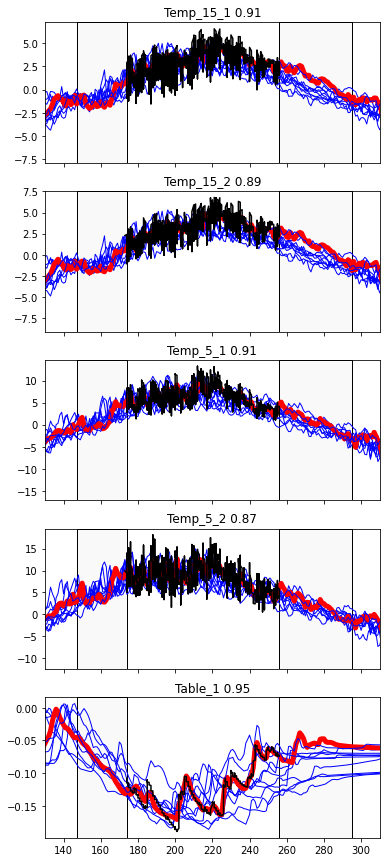

In [17]:
fig,ax=plt.subplots(len(Mods.keys()),sharex=True,figsize=(6,len(Mods.keys())*3))
j = 0
for Y in Mods.keys():
#     print(Mods[y]['X'])
    X = list(Mods[Y]['X'])
    y = [Y]
    print(Mods[Y]['Stats'])
    Val = Model_Test(X,y,Data.loc[~Data[X].T.isnull().any()],
                                K=K,Test = 'OLS',Scale=True,Task='Predict',Verbose=False)
    Data[Y+'_OLS']=np.nan
    Data.loc[~Data[X].T.isnull().any(),Y+'_OLS']=Val
                     
    DNA = Data[y+[Y+'_OLS']].dropna()
    print()
    print('r2: ',metrics.r2_score(DNA[y],DNA[Y+'_OLS']))
    print('RMSE: ',metrics.mean_squared_error(DNA[y],DNA[Y+'_OLS'])**.5)


    for y in range(2009,2020):
        Yr = Data.loc[Data.index.year==y].resample('D').mean()
        if y == 2017:
            ax[j].plot(Yr['DOY'],Yr[Y+'_OLS'],color='r',linewidth=5)
        else:
            ax[j].plot(Yr['DOY'],Yr[Y+'_OLS'],color='b',linewidth=1)
    ax[j].plot(Data['DOY'],Data[Y],color='k')
    ax[j].set_title(Y+' '+ str(Mods[Y]['Stats']['R2'].round(2).values[0]))


    ax[j].axvspan(147,174,facecolor=[.97,.97,.97,.65],edgecolor='k')
    ax[j].axvspan(256,295,facecolor=[.97,.97,.97,.65],edgecolor='k')
    ax[j].set_xlim(130,310)
    j +=1

In [18]:
Y = 'Test'
SE_Rule = 2
Met = [
    'Net_LW',
    'Net_SW',
    'Wind_Speed',
    'Air_Temp',
    'Rainfall'
    ]
ERA5_Met = [
    'temperature_2m',
    'dewpoint_temperature_2m',
    'Wind_10m',
    'HH',
    ]
AllX = Met+ERA5_Met
print(len(AllX))
Mods = {}
for y in [['u*'],['PPFD_Avg'],['NR_Wm2_Avg']]:
    X = AllX
    res = {
        'X':X,
        'Score':np.ones(len(X))/len(X)
    }
    Results = pd.DataFrame(data=res)
    K = 30
    Track = {'i':[],
            'Rem':[],
            'RMSE':[],
            'RMSES':[],
            'R2':[],
            'R2S':[]}
    for i in range(len(X)):
        X = list(Results.X.values)
        Val,C,I,MSE,R2 = Model_Test(X,y,Data.loc[~Data[X].T.isnull().any()],K=K,
                             Test = 'OLS',Scale=True,Task='Predict_Return',Verbose=False)
        MSE = np.array(MSE)**.5
        Results['Score'] = C**2/(C**2).sum()
        Results = Results.sort_values('Score')
        Rem = Results.loc[Results['Score']==Results['Score'].min(),'X'].values[0]
        Results = Results.loc[Results['Score']>Results['Score'].min()]
        Track['i'].append(len(X))
        Track['R2'].append(np.mean(np.array(R2)))
        Track['R2S'].append(np.std(np.array(R2)))
        Track['RMSE'].append(MSE.mean())
        Track['RMSES'].append(MSE.std())#/(MSE.shape[0]**.5))
        Track['Rem'].append(Rem)

    Track = pd.DataFrame(data=Track)
    Track = Track.set_index('i')
    Track['RMSESS'] = (Track['RMSE'] + Track['RMSES']*SE_Rule)
    Track['R2SS'] = (Track['R2'] - Track['R2S']*SE_Rule)
    Mods[y[0]] = {}
    Sel = Track.loc[Track['RMSE']<Track['RMSESS'].min(),['RMSE','RMSES','R2','R2S']][-1:]
    M = Track.loc[Track.index<=Sel.index.values[0],'Rem'].values
    Mods[y[0]]['Stats']=Sel
    Mods[y[0]]['X']=M
    print(y)
    print(M)
    print(Sel)
    print(Track)
    print()

9
['u*']
['Wind_Speed']
       RMSE     RMSES       R2       R2S
i                                       
1  0.045001  0.003854  0.89794  0.017879
                       Rem      RMSE     RMSES        R2       R2S    RMSESS  \
i                                                                              
9                   Net_LW  0.043019  0.003516  0.906991  0.014724  0.050052   
8                 Rainfall  0.043002  0.003525  0.907050  0.014813  0.050052   
7                 Wind_10m  0.042989  0.003561  0.907097  0.014896  0.050111   
6  dewpoint_temperature_2m  0.042987  0.003635  0.907086  0.015154  0.050258   
5           temperature_2m  0.043034  0.003661  0.906890  0.015253  0.050356   
4                   Net_SW  0.043031  0.003652  0.906895  0.015289  0.050336   
3                 Air_Temp  0.043114  0.003662  0.906527  0.015405  0.050438   
2                       HH  0.043622  0.004066  0.904160  0.017376  0.051754   
1               Wind_Speed  0.045001  0.003854  0.897

       RMSE     RMSES       R2       R2S
i                                       
1  0.045001  0.003854  0.89794  0.017879

u*
RMSE 0.04500149440521988
std RMSE 0.0038542468485703893
r2 0.8948652491619089
coef [0.13501616]
int 0.3044481420598676

r2:  0.8998657373147907
RMSE:  0.045041291088142706
        RMSE     RMSES       R2       R2S
i                                        
1  38.631624  2.556721  0.99004  0.001961

PPFD_Avg
RMSE 38.63162448677515
std RMSE 2.556720946270257
r2 0.9904007390827857
coef [389.66543789]
int 333.84664621212124

r2:  0.990258864514813
RMSE:  38.64921631423895
        RMSE     RMSES        R2       R2S
i                                         
2  25.407165  3.006776  0.977671  0.005253

NR_Wm2_Avg
RMSE 25.40716521283219
std RMSE 3.006775863622788
r2 0.978587292087777
coef [ 38.01871336 198.6623065 ]
int 108.98780883838383

r2:  0.9778811856277201
RMSE:  25.54095679878888


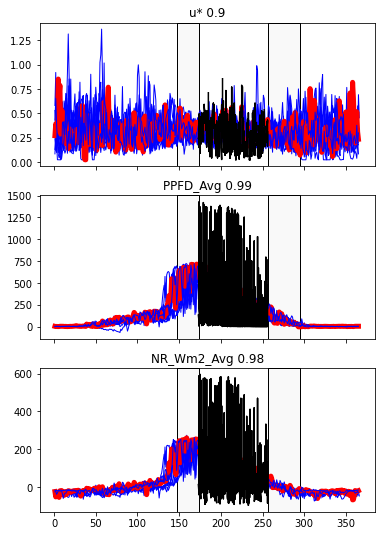

In [19]:
fig,ax=plt.subplots(len(Mods.keys()),sharex=True,figsize=(6,len(Mods.keys())*3))
j = 0
for Y in Mods.keys():
#     print(Mods[y]['X'])
    X = list(Mods[Y]['X'])
    y = [Y]
    print(Mods[Y]['Stats'])
    Val = Model_Test(X,y,Data.loc[~Data[X].T.isnull().any()],
                                K=K,Test = 'OLS',Scale=True,Task='Predict',Verbose=True)
    Data[Y+'_OLS']=np.nan
    Data.loc[~Data[X].T.isnull().any(),Y+'_OLS']=Val
                     
    DNA = Data[y+[Y+'_OLS']].dropna()
    print()
    print('r2: ',metrics.r2_score(DNA[y],DNA[Y+'_OLS']))
    print('RMSE: ',metrics.mean_squared_error(DNA[y],DNA[Y+'_OLS'])**.5)


    for y in range(2009,2020):
        Yr = Data.loc[Data.index.year==y].resample('D').mean()
        if y == 2017:
            ax[j].plot(Yr['DOY'],Yr[Y+'_OLS'],color='r',linewidth=5)
        else:
            ax[j].plot(Yr['DOY'],Yr[Y+'_OLS'],color='b',linewidth=1)
    ax[j].plot(Data['DOY'],Data[Y],color='k')
    ax[j].set_title(Y+' '+ str(Mods[Y]['Stats']['R2'].round(2).values[0]))
    
    ax[j].axvspan(147,174,facecolor=[.97,.97,.97,.65],edgecolor='k')
    ax[j].axvspan(256,295,facecolor=[.97,.97,.97,.65],edgecolor='k')
    j +=1

In [20]:
Data['Rolling_Rainfall_D14']=Data['Rainfall'].rolling(str(14)+'D').sum()
Data['Rolling_Rainfall_D6']=Data['Rainfall'].rolling(str(6)+'D').sum()
Data['Rolling_Rainfall_D3']=Data['Rainfall'].rolling(str(3)+'D').sum()
Data['Rolling_Rainfall_D']=Data['Rainfall'].rolling(str(1)+'D').sum()

Data['Rolling_Air_Temp_D3']=Data['Air_Temp'].rolling(str(3)+'D').mean()
Data['Rolling_Air_Temp_D']=Data['Air_Temp'].rolling(str(1)+'D').mean()

Data['Rolling_Air_TempH1']=Data['Air_Temp'].rolling(str(6)+'H').mean()
Data['Rolling_Air_TempH2']=Data['Air_Temp'].rolling(str(12)+'H').mean()
Data['Rolling_Air_TempH3']=Data['Air_Temp'].rolling(str(18)+'H').mean()

Y = 'Test'

SE_Rule = 2

Met = [
    
#     'Net_RN',
#     'Wind_Speed',
    'Air_Temp',
#     'Rainfall'
    ]
ERA5_Met = [
    'temperature_2m',
    'dewpoint_temperature_2m',
    'W_Dir_ERA5',
#     'Wind_10m',
#     'HH',
    ]


AllX = Met+ERA5_Met
print(len(AllX))

Mods = {
}
for y in [['VPD']]:
    X = AllX
    res = {
        'X':X,
        'Score':np.ones(len(X))/len(X)
    }
    Results = pd.DataFrame(data=res)
    K = 10
    Track = {'i':[],
            'Rem':[],
            'RMSE':[],
            'RMSES':[],
            'R2':[],
            'R2S':[]}
    for i in range(len(X)):
        X = list(Results.X.values)
        Val,C,MSE,R2 = Model_Test(X,y,Data.loc[~Data[X].T.isnull().any()],K=K,
                             Test = 'RF',Task='Predict_Return',Verbose=False,min_samples_split=2)
        MSE = np.array(MSE)**.5
        Results['Score'] = C#/C.sum()
        Results = Results.sort_values('Score')
        Rem = Results.loc[Results['Score']==Results['Score'].min(),'X'].values[0]
        Results = Results.loc[Results['Score']>Results['Score'].min()]
        Track['i'].append(len(X))
        Track['R2'].append(np.mean(np.array(R2)))
        Track['R2S'].append(np.std(np.array(R2)))
        Track['RMSE'].append(MSE.mean())
        Track['RMSES'].append(MSE.std())#/(MSE.shape[0]**.5))
        Track['Rem'].append(Rem)

    Track = pd.DataFrame(data=Track)
    Track = Track.set_index('i')
    Track['RMSESS'] = (Track['RMSE'] + Track['RMSES']*SE_Rule)
    Track['R2SS'] = (Track['R2'] - Track['R2S']*SE_Rule)
    Mods[y[0]] = {}
    Sel = Track.loc[Track['RMSE']<Track['RMSESS'].min(),['RMSE','RMSES','R2','R2S']][-1:]
    M = Track.loc[Track.index<=Sel.index.values[0],'Rem'].values
    Mods[y[0]]['Stats']=Sel
    Mods[y[0]]['X']=M
    print(y)
    print(M)
    print(Sel)
    print(Track)
    
    print()

4
['VPD']
['temperature_2m' 'dewpoint_temperature_2m' 'Air_Temp']
         RMSE      RMSES        R2      R2S
i                                          
3  109.436241  10.164922  0.904358  0.02754
                       Rem        RMSE      RMSES        R2       R2S  \
i                                                                       
4               W_Dir_ERA5  100.594252   9.684403  0.919030  0.024542   
3           temperature_2m  109.436241  10.164922  0.904358  0.027540   
2  dewpoint_temperature_2m  120.150011   8.067814  0.884951  0.029899   
1                 Air_Temp  169.981249   7.801545  0.770562  0.047739   

       RMSESS      R2SS  
i                        
4  119.963059  0.869946  
3  129.766086  0.849278  
2  136.285639  0.825153  
1  185.584338  0.675084  



         RMSE      RMSES        R2      R2S
i                                          
3  109.436241  10.164922  0.904358  0.02754

r2:  0.9833208568058639
RMSE:  46.66432039271478


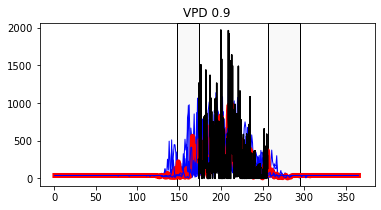

In [21]:
fig,ax=plt.subplots(len(Mods.keys()),sharex=True,figsize=(6,len(Mods.keys())*3))
if len(Mods.keys())==1:
    ax = [ax]
j = 0
for Y in Mods.keys():
#     print(Mods[y]['X'])
    X = list(Mods[Y]['X'])
    y = [Y]
    print(Mods[Y]['Stats'])
    Val = Model_Test(X,y,Data.loc[~Data[X].T.isnull().any()],
                                K=K,Test = 'RF',Scale=True,Task='Predict',Verbose=False,min_samples_split=2)
    Data[Y+'_RF']=np.nan
    Data.loc[~Data[X].T.isnull().any(),Y+'_RF']=Val
                     
    DNA = Data[y+[Y+'_RF']].dropna()
    print()
    print('r2: ',metrics.r2_score(DNA[y],DNA[Y+'_RF']))
    print('RMSE: ',metrics.mean_squared_error(DNA[y],DNA[Y+'_RF'])**.5)


    for y in range(2009,2020):
        Yr = Data.loc[Data.index.year==y].resample('D').mean()
        if y == 2017:
            ax[j].plot(Yr['DOY'],Yr[Y+'_RF'],color='r',linewidth=5)
        else:
            ax[j].plot(Yr['DOY'],Yr[Y+'_RF'],color='b',linewidth=1)
    ax[j].plot(Data['DOY'],Data[Y],color='k')
    ax[j].set_title(Y+' '+ str(Mods[Y]['Stats']['R2'].round(2).values[0]))


    ax[j].axvspan(147,174,facecolor=[.97,.97,.97,.65],edgecolor='k')
    ax[j].axvspan(256,295,facecolor=[.97,.97,.97,.65],edgecolor='k')
    j +=1

In [101]:

Daily = Data.resample('D').mean()
Daily = Daily.loc[((Daily.index.month>=5)|(Daily.index.month<=10))]
print(Daily[['ndvi_FI_LCP','NDSI_FI_LCP']].corr()**2)

Y = 'NDSI_FI_LCP_RF'
# X = list(Mods[Y]['X'#])
X=['DOY','snow_cover','NDVI_interp']
y = ['NDSI_FI_LCP']
# print(Mods[Y]['Stats'])
Val = Model_Test(X,y,Daily.loc[~Daily[X].T.isnull().any()],
                            K=K,Test = 'RF',Scale=True,Task='Predict',Verbose=True,min_samples_split=2)
Daily['NDSI_RF_Fill']=Daily['NDSI_FI_LCP'].copy()
Daily[Y]=np.nan
Daily.loc[~Daily[X].T.isnull().any(),Y]=Val
Daily['NDSI_RF_Fill']=Daily['NDSI_RF_Fill'].fillna(Daily[Y])
Data['NDSI_RF_Fill']=np.nan
Data['NDSI_RF_Fill']=Daily.resample('H').interpolate()['NDSI_RF_Fill']


             ndvi_FI_LCP  NDSI_FI_LCP
ndvi_FI_LCP     1.000000     0.765337
NDSI_FI_LCP     0.765337     1.000000

NDSI_FI_LCP
RMSE 10.565701657295236
std RMSE 0.8580054374149386
r2 0.908593185784485
Imp [ 5.8 39.3 54.9]


<IPython.core.display.Javascript object>


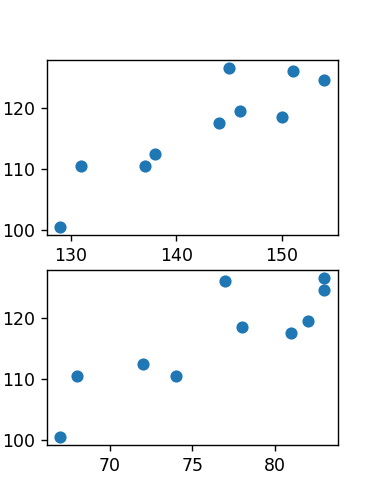

AL Comparisson
Reindeer Depot  (Thaw tube)
0.7956129281660832

Lousy Point (Thaw tube)
0.7313693269324402
             Reindeer Depot  (Thaw tube)  Lousy Point (Thaw tube)
Air_Temp                           0.476                    0.490
Snow_Sum                           0.740                    0.490
Season_Sum                         0.792                    0.722
Snow_Day                           0.548                      NaN
End_Day                            0.578                    0.336
Season_Root                        0.792                    0.740


In [110]:
NDSI = 'NDSI_interp'
NDSI = 'NDSI_RF_Fill'
# NDSI = 'snow_cover'
Snow_Thresh=25
Daily['snow_cover']=Data.resample('D').min()['snow_cover']
Daily['Rainfall']=Data.resample('D').sum()['Rainfall']
Daily = Daily.loc[((Daily.index.month>=5)&(Daily.index.month<=10))]
Flood = Daily.loc[((Daily.index.month>=5)&(Daily.index.month<=6))].copy()
data={'Year':[],'Peak_Day':[],'Peak_Height':[],'Peak_NDVI':[],'Peak_Snow':[]}
for y in range(2008,2021):
    Fy=Flood.loc[Flood.index.year==y].copy()
    Sf=Daily.loc[((Daily.index.year==y)&(Daily.index.month>=7))].copy()
    for s in ['KULUARPAK']:
        if Fy[s].count()/(1464/24)>.8:
            v=Fy[s].max()
            d = Fy.loc[((Fy[s]==v))].index.dayofyear[0]
            K = (Daily.loc[((Daily.index.year==y)&(Daily['DOY']==d)),[NDSI,'NDVI_interp']].values[0])
        else:
            v=np.nan
            d=np.nan
            K=[np.nan,np.nan]
        data['Year'].append(y)
        data['Peak_Day'].append(d)
        data['Peak_Height'].append(v)
        data['Peak_Snow'].append(K[0])
        data['Peak_NDVI'].append(K[1])
        
FDF = pd.DataFrame(data=data)
Daily['Freezing']=1
Daily.loc[Daily['Air_Temp']<0,'Freezing']=0

Flood_Thresh = 0.1
GS_Thresh = 0.25
Daily['Green']=1
Daily.loc[Daily['NDVI_interp']<Flood_Thresh,'Green']=np.nan
Daily.loc[Daily['NDVI_interp']<GS_Thresh,'Green']=0.5

Daily['Snow']=1
Daily.loc[Daily[NDSI]>Snow_Thresh,'Snow']=0

Daily['Season']=0
Daily['Season'] = Daily['Snow']*Daily['Freezing']*Daily['Green']

Daily['Snow_Day'] = Daily['Snow']*Daily.index.dayofyear
Daily.loc[Daily['Snow_Day']==0,'Snow_Day']=np.nan
Daily['Season_Day'] = Daily['Season']*Daily.index.dayofyear
Daily.loc[Daily['Season']==0.5,'Season_Day']/=2
Daily.loc[Daily['Season_Day']==0,'Season_Day']=np.nan

for y in range(2008,2021):
    Year = Daily.loc[Daily.index.year==y].copy()
    Year['Snow_Sum'] = Year['Snow'].cumsum()
    Year['Freezing_Sum'] = Year['Freezing'].cumsum()
    Year['Season_Sum'] = Year['Season'].cumsum()
    Daily.loc[Daily.index.year==y,'Snow_Sum']=Year['Snow_Sum']*1
    Daily.loc[Daily.index.year==y,'Freezing_Sum']=Year['Freezing_Sum']*1
    Daily.loc[Daily.index.year==y,'Season_Sum']=Year['Season_Sum']*1
    FDF.loc[FDF.Year==y,'Snow_Sum']=Year['Snow_Sum'].max()
    FDF.loc[FDF.Year==y,'Freezing_Sum']=Year['Freezing_Sum'].max()
    FDF.loc[FDF.Year==y,'Season_Sum']=Year['Season_Sum'].max()
    FDF.loc[FDF.Year==y,'Melt_Day'] = Year['Snow_Day'].min()
    FDF.loc[FDF.Year==y,'Snow_Day'] = Year['Snow_Day'].max()
    FDF.loc[FDF.Year==y,'Start_Day'] = Year['Season_Day'].min()
    FDF.loc[FDF.Year==y,'End_Day'] = Year['Season_Day'].max()
    Year.loc[Year['Season']<=0,'Season']=np.nan
    Year['SeasonF']=Year['Season'].ffill()
    Year['SeasonB']=Year['Season'].bfill()
    Year['Season'] = Year['SeasonF']*Year['SeasonB']
    Daily.loc[Daily.index.year==y,'Season']=Year['Season']

Daily['Season_Root']=Daily['Season_Sum']**.5
FDF['Season_Root']=FDF['Season_Sum']**.5

Ary = {
        'A':44.5-np.array([23, 21.5, 23.5, 23, 21.5, 23, 22, 22, 22.5, 23.5,]) ,    
        'B':np.array([28, 28, 28, 32, 30, 30, 30, 32, 28, 29,]),    
        'C':np.array([34, 33, 36, 37, 36, 35, 34, 34, 36, 35,]),    
        'D':np.array([40, 40, 41, 42, 43, 46, 44, 48, 43, 44,]),
        'E':np.array([53, 51, 54, 52, 54, 54, 53, 49, 47, 46,])
        }
DD = ['2017-6-22','2017-7-10','2017-8-1','2017-8-21','2017-9-13']
P = []
for d in DD:
    P.append(10)

D = [DD[i] for i,p in enumerate(P) for s in range(p) ]
KK = [
      'A','B','C','D','E']
AP = []
DT = []

for d,k,p in zip (DD,KK,P):
    AP.append(Ary[k])
    DT.append(np.array([d for i in range(p)]))
Set = {'Active_Layer_1':np.hstack(AP)/100,
             'Dt':np.hstack(DT)}    
AL_obs = pd.DataFrame(data=Set)

AL_obs['Date'] = pd.DatetimeIndex(AL_obs['Dt'])
AL_obs=AL_obs.set_index('Date')

ALH=pd.read_csv(Output_Path+'AL_Depth.csv',header=[1])
AL=pd.read_csv(Output_Path+'AL_Depth.csv',skiprows=4)
AL.columns=ALH.columns
AL=AL.rename(columns={'Name':'Year'})
AL = AL.set_index('Year')

AL = AL[['Reindeer Depot  (Thaw tube)','Lousy Point (Thaw tube)']].dropna()

T = Daily.loc[Daily.index.year>=2008].resample('Y').mean()[['Air_Temp']]
T['Year']=T.index.year
T = T.set_index('Year')
AL = AL.join(T).join(FDF.set_index('Year'))#.join(Days)

C = ((AL.corr()).round(2)[['Reindeer Depot  (Thaw tube)','Lousy Point (Thaw tube)']][2:])
S = np.sign(C)#*10
C = S.multiply(C**2).round(3)
C[C.abs()<.3]=np.nan

fig,ax=plt.subplots(2,figsize=(3,4))
ax[0].scatter(AL['Reindeer Depot  (Thaw tube)'],AL['Season_Sum'])
ax[1].scatter(AL['Lousy Point (Thaw tube)'],AL['Season_Sum'])

AL_s = 'Reindeer Depot  (Thaw tube)'
v = 'Season_Root'
df = AL[[AL_s,v]].dropna()
Mod = LinearRegression()
Mod.fit(df[[AL_s]], df[v])
Test = Mod.predict(df[[AL_s]])
print('AL Comparisson')
print(AL_s)
print(metrics.r2_score(df[v],Test))

AL_s = 'Lousy Point (Thaw tube)'
df = AL[[AL_s,v]].dropna()
Mod = LinearRegression()
Mod.fit(df[[AL_s]], df[v])
Test = Mod.predict(df[[AL_s]])
print()
print(AL_s)
print(metrics.r2_score(df[v],Test))
print(C[C.isnull().sum(axis=1)<2])
AL = AL.loc[AL.index>=2008].copy()
# AL

Data['Season']=Daily.resample('H').bfill()['Season']
Data['Season_Sum']=Daily.resample('H').interpolate()['Season_Sum']
Data['Season_Root']=Data['Season_Sum']**.5
Data[['Freezing','Green','Snow']]=Daily[['Freezing','Green','Snow']].resample('H').asfreq()
# Data['Season_Sum']=Data['Season_Sum']*(Data['Season']*0+1)
# Data['Season_Sum']=Data['Season_Sum']*(Data['Season']*0+1)
Data.loc[Data['Season'].isnull(),['Season_Sum','Season_Root']]=np.nan


Active_Layer_1
RMSE 0.024373592024352447
std RMSE 0.006049005822602998
r2 0.9194482800691091
coef [0.0506091]
int -0.01530945310470887


<IPython.core.display.Javascript object>


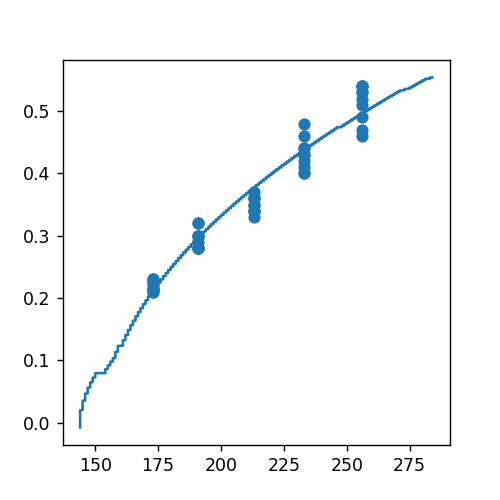


Reindeer Model:  0.743107402358284
Lousy Model:  0.6327017511190038

Reindeer Depot  (Thaw tube)    0.795613
Lousy Point (Thaw tube)        0.731369
Name: AL_data_est, dtype: float64


In [113]:
for v in ['DOY','Season_Sum','Season_Root',]:
    for d in AL_obs.index.unique():
        AL_obs.loc[AL_obs.index==d,v]=Daily.loc[Daily.index.date==d,v].values[0]

y=['Active_Layer_1']
Y = 'AL_data_est'
Lag = []
D = []
K = 10

X = ['Season_Sum']
X = ['Season_Root']

Val,C,I,RMSE,R2 = Model_Test(X,y,AL_obs.copy(),K=K,Test = 'OLS',Task='Predict_Return')
AL_obs[Y]=Val

Daily['AL_data_est'] = (Daily[X[0]])*C+I
Data['AL_data_est'] = (Data[X[0]])*C+I

Daily.loc[Daily['AL_data_est']<=0,'AL_data_est']=np.nan

fig,ax=plt.subplots(figsize=(4,4))
for y in range(2017,2018):
    Yr = Data.loc[Data.index.year==y]#.resample('D').mean()
    ax.plot(Yr['DOY'],Yr['AL_data_est'])#*Yr['DSF'])
ax.scatter(AL_obs['DOY'],AL_obs['Active_Layer_1'])

T = Daily.loc[Daily.index.year>=2008].resample('Y').max()[['AL_data_est']]
T['Year']=T.index.year
T = T.set_index('Year')
try:
    AL = AL.drop(columns='AL_data_est')
except:
    pass
AL = AL.join(T)
AL = AL.loc[AL['AL_data_est'].isnull()==False].copy()

y = ['Reindeer Depot  (Thaw tube)']
X=['AL_data_est']

Mod = LinearRegression()
DNA = AL[X+y].dropna()
Mod.fit(DNA[X], DNA[y])
Test = Mod.predict(DNA[X])

print()
print('Reindeer Model: ',metrics.r2_score(Test,DNA[y]))

y = ['Lousy Point (Thaw tube)']
Mod = LinearRegression()
DNA = AL[X+y].dropna()
Mod.fit(DNA[X], DNA[y])
Test = Mod.predict(DNA[X])


print('Lousy Model: ',metrics.r2_score(Test,DNA[y]))

print()
print(AL[['AL_data_est','Reindeer Depot  (Thaw tube)',y[0]]].corr()[1:]['AL_data_est']**2)


<IPython.core.display.Javascript object>


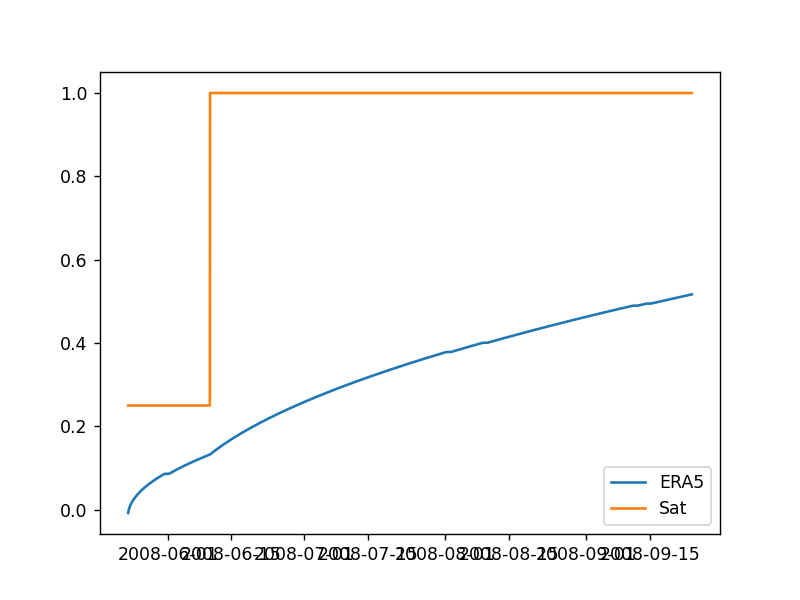

In [114]:

# Data.loc[Data['Season'].isnull(),['Season_Sum','Season_Root','AL_data_est']].describe()#=np.nan
Study_Year = Data.loc[Data.index.year==2008].copy()
# # 
# Study_Year.loc[Study_Year['Season']<=0,'Season']=np.nan
# Study_Year['SeasonF']=Study_Year['Season'].ffill()
# Study_Year['SeasonB']=Study_Year['Season'].bfill()
# Study_Year['Season'] = Study_Year['SeasonF']*Study_Year['SeasonB']

plt.figure()
plt.plot(Study_Year['AL_data_est'],label='ERA5')
plt.plot(Study_Year['Season'],label='Sat')
# plt.plot(Study_Year['NDSI_FI_LCP'])
# x2=plt.twinx()
# x2.plot(Study_Year['NDVI_interp'])
plt.legend()

# WX Summary Stats


In [115]:
print(AL.columns)
print(AL[['Peak_Day','Peak_Height','Peak_NDVI']].corr()**2)
print()
print(AL['Peak_NDVI'].median())
print(np.round(AL['Peak_Height'].max()-AL['Peak_Height'].min(),2))

print(AL['Start_Day'])
AL['Peak_Date'] = pd.to_datetime(AL.index * 1000 + AL['Peak_Day'], format='%Y%j')
AL['Start_Date'] = pd.to_datetime(AL.index * 1000 + AL['Start_Day'], format='%Y%j')
AL['End_Date'] = pd.to_datetime(AL.index * 1000 + AL['End_Day'], format='%Y%j')
Yrly = AL[['Peak_Height','Peak_Date','Start_Date','End_Date','Season_Sum','Start_Date']].sort_values(by='Season_Sum')
print(Yrly)

Index(['Reindeer Depot  (Thaw tube)', 'Lousy Point (Thaw tube)', 'Air_Temp',
       'Peak_Day', 'Peak_Height', 'Peak_NDVI', 'Peak_Snow', 'Snow_Sum',
       'Freezing_Sum', 'Season_Sum', 'Melt_Day', 'Snow_Day', 'Start_Day',
       'End_Day', 'Season_Root', 'AL_data_est'],
      dtype='object')
             Peak_Day  Peak_Height  Peak_NDVI
Peak_Day     1.000000     0.608680   0.032135
Peak_Height  0.608680     1.000000   0.169822
Peak_NDVI    0.032135     0.169822   1.000000

0.07667983405825486
0.65
Year
2008.0    36.25
2009.0    38.75
2010.0    38.00
2011.0    35.75
2012.0    36.00
2013.0    39.50
2014.0    36.50
2015.0    34.00
2016.0    35.00
2017.0    36.25
Name: Start_Day, dtype: float64
        Peak_Height  Peak_Date Start_Date   End_Date  Season_Sum Start_Date
Year                                                                       
2009.0       10.089 2009-06-04 2009-02-07 2009-09-22       100.5 2009-02-07
2008.0        9.949 2008-06-02 2008-02-05 2008-09-24       110.5 2008-0

In [116]:
# print(Daily)
Daily = Data.resample('D').mean()
Daily = Daily[Daily['Air_Temp'].isnull()==False]
# Daily.loc[Daily.index.year == 2009]

<IPython.core.display.Javascript object>


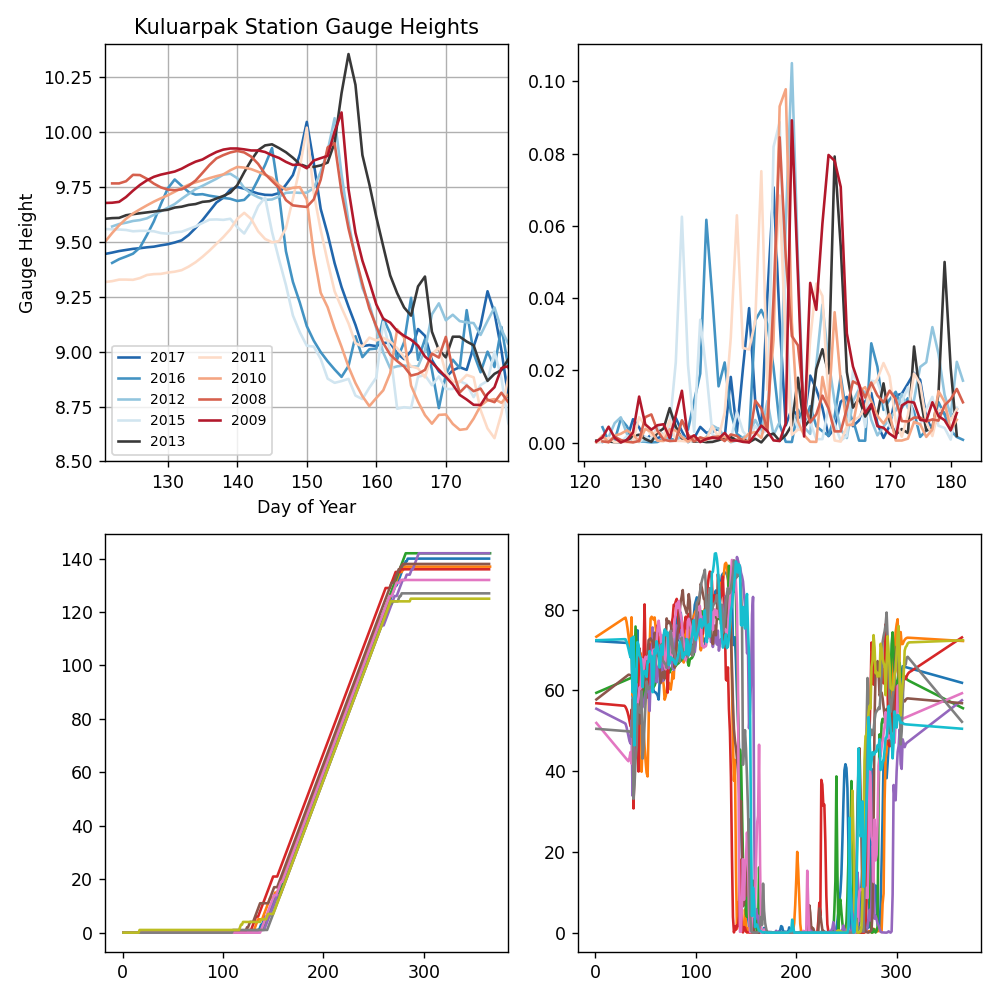

     Year  Warm_Days  Warm_First  Warm_Last
8  2009.0      125.0        17.0      287.0
7  2010.0      127.0       110.0      278.0
6  2011.0      132.0       138.0      277.0
2  2012.0      142.0       134.0      282.0
4  2013.0      142.0       137.0      295.0
5  2014.0      138.0       123.0      279.0
3  2015.0      136.0       128.0      277.0
1  2016.0      137.0       124.0      281.0
0  2017.0      140.0       136.0      284.0


In [117]:
# fig,ax = plt.subplots(figsize=(4,3.25))
fig,((ax,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))

C = [
'#b2182b',
'#d6604d',
'#f4a582',
'#fddbc7',
'#383838',
'#d1e5f0',
'#92c5de',
'#4393c3',
'#2166ac',
][::-1]
I = 0
# %matplotlib notebook

# Daily = Data.resample('Y').mean()
# Daily

Daily['Warm']=np.nan
Daily.loc[Daily['Air_Temp']>0,'Warm']=1

Study_Years = {'Year':[],
              'Warm_Days':[],
              'Warm_First':[],
              'Warm_Last':[]}

for y in Yrly.index[::-1]:
    Fy=Flood.loc[Flood.index.year==y].copy()
    YR = Daily.loc[Daily.index.year==y].copy()
#     for s in ['KULUARPAK']:
    if Fy['KULUARPAK'].count()/(1464/24)>.8:
        ax.plot(Fy.index.dayofyear,Fy['KULUARPAK'],color=C[I],label=str(int(y)))
        ax2.plot(Fy.index.dayofyear,Fy['NDVI_interp'].diff().abs(),color=C[I],label=str(int(y)))
        
        I += 1

    if y != 2008:
        Study_Years['Year'].append(y)
        Study_Years['Warm_Last'].append((YR['Warm']*YR['DOY']).max())
        Study_Years['Warm_First'].append((YR['Warm']*YR['DOY']).min())
        YR['Warm']=YR['Warm'].fillna(0)
        YR['Warm_Days']=YR['Warm'].cumsum()
        Study_Years['Warm_Days'].append(YR['Warm_Days'].max())
        ax3.plot(YR.index.dayofyear,YR['Warm_Days'])
    ax4.plot(YR.index.dayofyear,YR['NDSI_interp'])

        
Study_Stats = pd.DataFrame(data=Study_Years).sort_values(by='Year')
print(Study_Stats)
# ax3.bar(Study_Stats['Year'],Study_Stats['Warm_Last']-Study_Stats['Warm_First'],bottom=Study_Stats['Warm_First'])
# ax3.bar(Study_Stats['Year'],Study_Stats['Warm_Days'])
Save_Plots='C:\\Users\\User\\Google Drive\\PhD_Thesis\\Chapter3_Figs/'
ax.legend(ncol=2,handlelength=1.5,columnspacing=1,fontsize=8)
ax.set_ylim([8.5,10.4])
ax.set_xlim(121,179)
ax.grid()
ax.set_ylabel('Gauge Height')
ax.set_xlabel('Day of Year')
ax.set_title('Kuluarpak Station Gauge Heights')
# ax.set_xticks()
plt.tight_layout()
# plt.savefig(Save_Plots+'Gauge.png',dpi=600,bbox_inches='tight', pad_inches=0.05)

<IPython.core.display.Javascript object>


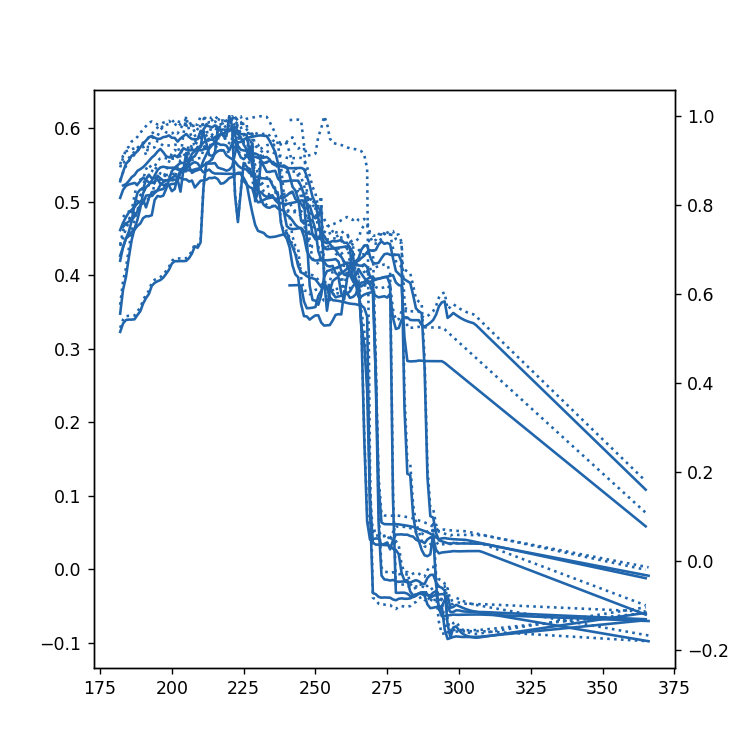

In [118]:
# fig,ax = plt.subplots(figsize=(4,3.25))
%matplotlib notebook
fig,ax = plt.subplots(1,figsize=(6,6))

C = [
'#b2182b',
'#d6604d',
'#f4a582',
'#fddbc7',
'#383838',
'#d1e5f0',
'#92c5de',
'#4393c3',
'#2166ac',
][::-1]
I = 0
# %matplotlib notebook

# Daily = Data.resample('Y').mean()
# Daily

Daily['Warm']=np.nan
Daily.loc[Daily['Air_Temp']>0,'Warm']=1

Study_Years = {'Year':[],
              'Warm_Days':[],
              'Warm_First':[],
              'Warm_Last':[]}

ax2=ax.twinx()
for y in Yrly.index[::-1]:
    if y >= 2008:
        Sf=Daily.loc[((Daily.index.year==y)&(Daily.index.month>=7))].copy()
#         print(Sf['NDVI_interp'])
        YR = Daily.loc[Daily.index.year==y].copy()
#         if Fy['KULUARPAK'].count()/(1464/24)>.8:
        ax.plot(Sf.index.dayofyear,Sf['NDVI_interp'],color=C[I],label=str(int(y)))
        ax2.plot(Sf.index.dayofyear,Sf['NDVI_interp']/Sf['NDVI_interp'].max(),color=C[I],label=str(int(y)),linestyle=':')
#             ay.plot(Fy['KULUARPAK'],Fy['NDVI_interp'],color=C[I])
#             I += 1
# ax.scatter(Yrly['Day_end'],Yrly['End_height'])
# Study_Stats = pd.DataFrame(data=Study_Years).sort_values(by='Year')
# print(Study_Stats)
# Save_Plots='C:\\Users\\User\\Google Drive\\PhD_Thesis\\Chapter3_Figs/'
# ax.legend(ncol=2,handlelength=1.5,columnspacing=1,fontsize=8)
# # ax.set_ylim([8.5,10.4])
# ax.set_xlim(121,179)
# ax.grid()
# ax.set_ylabel('Gauge Height')
# ax.set_xlabel('Day of Year')
# ax.set_title('Kuluarpak Station Gauge Heights')
# # ax.set_xticks()
# plt.tight_layout()
# plt.savefig(Save_Plots+'Gauge.png',dpi=600,bbox_inches='tight', pad_inches=0.05)

# Outputs

In [119]:
cols =['fch4','fco2','ch4_flux','co2_flux','Air_Temp','Rainfall','Wind_Speed','Wind_Direction',
        'Net_SW','Net_LW','Net_RN','Daytime','temperature_2m','dewpoint_temperature_2m',
       'volumetric_soil_water_layer_1','volumetric_soil_water_layer_2',
#        'volumetric_soil_water_layer_3',
#        'volumetric_soil_water_layer_4',
       'soil_temperature_level_1','soil_temperature_level_2',
       'soil_temperature_level_3',#'soil_temperature_level_4',
       'DOY',
       'NDSI_FI_LCP','ndvi_FI_LCP','GPP_FI_LCP',
       'snow_cover',
       'NDSI_interp','GPP_interp','NDVI_interp',
       'Polygon','Rim','Polygon_Obs',
       'Rim_Obs',
       'VPD_RF',
       'Wind_Speed',
      'Net_RN',
       'Temp_5_1_OLS',
       'Temp_15_2_OLS',
       'Temp_15_1_OLS',
       'Temp_5_2_OLS',
       'VPD_RF',
       'PPFD_Avg_OLS',
       'u*_OLS',
       'Table_1_OLS',
       'AL_data_est',
       'Freezing','Green','Snow',
#        'Ts_15_1_OLS','Ts_5_1_OLS,','Ts_15_2_OLS','Ts_5_2_OLS',#'VPD_OLS',
#        'PPFD_AWS_RF','u*_est_RF','WTD_RF','AL_data_est_RF',
       'NEE_FSO','NME_FSO','Season_Sum','Season_Root',#'Season_Sum2',
       'Season',#,'Season2','Season3',
      'Daytime',
      ]

RN = {'Wind_Speed':'wind_speed',
      'Net_RN':'NR_Wm2_Avg',
       'Temp_5_1_OLS':'Temp_5_1',
       'Temp_15_2_OLS':'Temp_15_2',
       'Temp_15_1_OLS':'Temp_15_1',
       'Temp_5_2_OLS':'Temp_5_2',
       'VPD_RF':'VPD',
       'PPFD_Avg_OLS':'PPFD_Avg',
       'u*_OLS':'u*',
       'Table_1_OLS':'Table_1',
       'AL_data_est':'Active_Layer_1',
     }

Data['Polygon_Obs'] = Data['Polygon'].copy()
Data['Polygon']=Data['Polygon'].median()
Data['Rim_Obs'] = Data['Rim'].copy()
Data['Rim']=Data['Rim'].median()


for col in RN:
#     print(columns)
    Data[RN[col]+'_FO'] = Data[RN[col]].copy()
    Data[RN[col]+'_Diff'] = Data[RN[col]+'_FO']-Data[col]
    cols.append(RN[col]+'_FO')
    cols.append(RN[col]+'_Diff')

# Path = 'G:/My Drive/FishIsland_Outputs/Network_Outputs/Arctic_Sci_8Vars/'
    
Export = Data.copy()
Export.index.name = 'datetime'
Export.index = Export.index.tz_localize(None)
Export = Export.loc[((Export.index.month>=5)&(Export.index.month<=10))]
Export[cols].rename(columns=RN).to_csv(Output_Path+'Network_Outputs/Arctic_Sci_8Vars/AWS_FI_Test.csv')
# Export[cols].rename(columns=RN).to_csv('C:\\Users\\wesle\\NetworkAnalysis\\FishIsland/AWS_FI_Test.csv')
print('Done')

Done
